# **Lstm ** with original data

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 6.9149e-04 - val_loss: 9.4907e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2127e-04 - val_loss: 3.1428e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1902e-05 - val_loss: 2.6089e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5643e-05 - val_loss: 2.4987e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2937e-05 - val_loss: 2.3936e-05
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0725e-05 - val_loss: 2.2079e-05
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3076e-05 - val_loss: 2.1159e-05
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2182e-05 - val_loss: 2.1217e-05
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8277e-05 - val_loss: 1.9682e-05
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4041e-05 - val_loss: 1.9504e-05
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6422

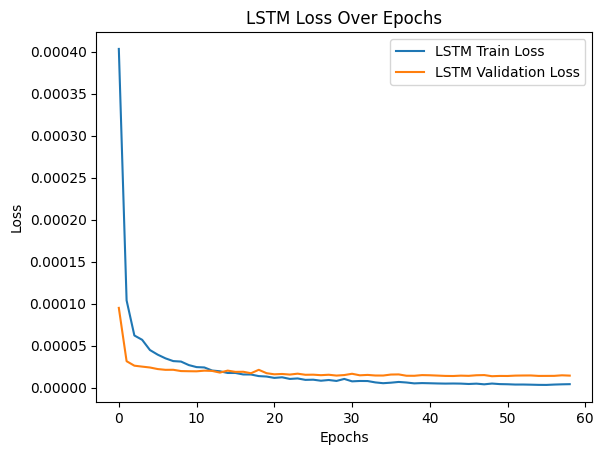

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load the Dataset
data = pd.read_csv('normalized gpa form.csv')
data

# Step 2: Handle Missing Data
# Impute numerical columns with their median
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
data[numerical_columns] = imputer_num.fit_transform(data[numerical_columns])

# Impute categorical columns with the most frequent value
categorical_columns = data.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = imputer_cat.fit_transform(data[categorical_columns])

# Step 3: Encoding Categorical Variables
# Label Encoding for binary categories and One-Hot Encoding for others
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

for col in categorical_columns:
    if data[col].nunique() == 2:  # Binary categories
        data[col] = label_encoder.fit_transform(data[col])
    else:  # Non-binary categories
        encoded = one_hot_encoder.fit_transform(data[[col]])
        encoded_df = pd.DataFrame(encoded, columns=[f"{col}_{cat}" for cat in one_hot_encoder.categories_[0][1:]])
        data = pd.concat([data, encoded_df], axis=1)
        data.drop(columns=[col], inplace=True)

# Step 4: Feature Scaling
# Assuming 'current_cgpa' is the target
target_column = 'current_cgpa'
X = data.drop(columns=[target_column]).values
y = data[target_column].values

# Scaling features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Step 5: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 6: Build and Train LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Step 7: Evaluate LSTM Model
lstm_loss = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Loss: {lstm_loss}")

# Plotting the training and validation loss for LSTM
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 8: Make Predictions using LSTM


# Step 9: Build and Train BiLSTM Model


In [ ]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)  # Reverse scaling for predictions
y_test_actual = scaler_y.inverse_transform(y_test)  # Reverse scaling for actual values

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test_actual - y_pred_lstm) / y_test_actual)) * 100

print("LSTM Metrics:")
print(f"R²: {r2_lstm}")
print(f"MSE: {mse_lstm}")
print(f"RMSE: {rmse_lstm}")
print(f"MAE: {mae_lstm}")
print(f"MAPE: {mape_lstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
LSTM Metrics:
R²: -0.04002055818237382
MSE: 50.99517492305192
RMSE: 7.141090597594454
MAE: 0.8307014095721467
MAPE: 102.41280468163909


# **BIlstm** with orignial data

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0010 - val_loss: 1.0230e-04
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7144e-04 - val_loss: 3.2419e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.9593e-05 - val_loss: 2.4486e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2418e-05 - val_loss: 2.4530e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6640e-05 - val_loss: 2.2876e-05
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.3801e-05 - val_loss: 2.4144e-05
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9106e-05 - val_loss: 1.9886e-05
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.2450e-05 - val_loss: 1.9573e-05
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2776e-05 - val_loss: 1.7881e-05
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7157e-05 - val_loss: 1.8869e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 
BiLSTM Tes

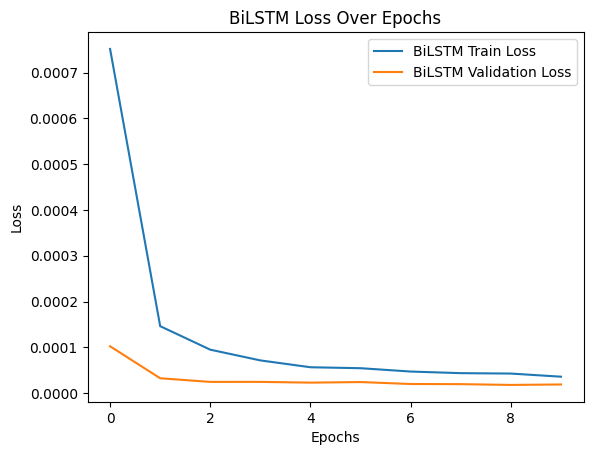

In [ ]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the BiLSTM model
bilstm_history = bilstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Step 10: Evaluate BiLSTM Model
bilstm_loss = bilstm_model.evaluate(X_test, y_test)
print(f"BiLSTM Test Loss: {bilstm_loss}")

# Plotting the training and validation loss for BiLSTM
plt.plot(bilstm_history.history['loss'], label='BiLSTM Train Loss')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM Validation Loss')
plt.title('BiLSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 11: Make Predictions using BiLSTM



In [ ]:
y_pred_bilstm = bilstm_model.predict(X_test)
y_pred_bilstm = scaler_y.inverse_transform(y_pred_bilstm)  # Reverse scaling for predictions
y_test_actual = scaler_y.inverse_transform(y_test)  # Reverse scaling for actual values

# Calculate metrics for BiLSTM
mse_bilstm = mean_squared_error(y_test_actual, y_pred_bilstm)
rmse_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_actual, y_pred_bilstm)
r2_bilstm = r2_score(y_test_actual, y_pred_bilstm)
mape_bilstm = np.mean(np.abs((y_test_actual - y_pred_bilstm) / y_test_actual)) * 100

print("BiLSTM Metrics:")
print(f"R²: {r2_bilstm}")
print(f"MSE: {mse_bilstm}")
print(f"RMSE: {rmse_bilstm}")
print(f"MAE: {mae_bilstm}")
print(f"MAPE: {mape_bilstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step
BiLSTM Metrics:
R²: -0.008128915383179836
MSE: 49.43143669659736
RMSE: 7.030749369490947
MAE: 1.3040126578301345
MAPE: 206.25531946459722


# **latm with log transformed**


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1095 - val_loss: 0.0041
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - val_loss: 0.0022
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val

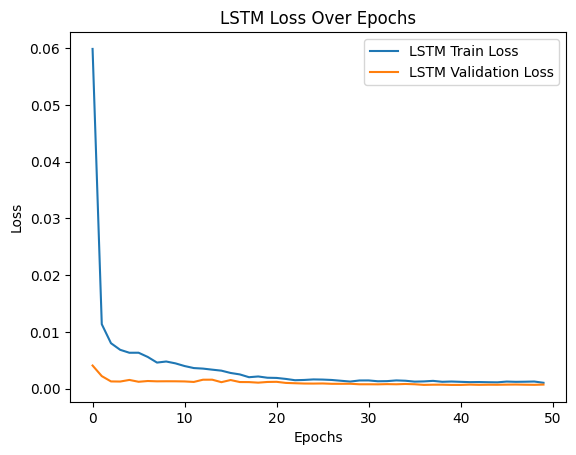

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Mean Squared Error: 0.015017247473052652
Mean Absolute Error: 0.047914674601682083
R^2 Score: 0.3227219312854246


In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load the Dataset
data = pd.read_csv('normalized gpa form.csv')
data

# Step 2: Handle Missing Data
# Impute numerical columns with their median
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
data[numerical_columns] = imputer_num.fit_transform(data[numerical_columns])

# Impute categorical columns with the most frequent value
categorical_columns = data.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = imputer_cat.fit_transform(data[categorical_columns])

# Step 3: Encoding Categorical Variables
# Label Encoding for binary categories and One-Hot Encoding for others
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

for col in categorical_columns:
    if data[col].nunique() == 2:  # Binary categories
        data[col] = label_encoder.fit_transform(data[col])
    else:  # Non-binary categories
        encoded = one_hot_encoder.fit_transform(data[[col]])
        encoded_df = pd.DataFrame(encoded, columns=[f"{col}_{cat}" for cat in one_hot_encoder.categories_[0][1:]])
        data = pd.concat([data, encoded_df], axis=1)
        data.drop(columns=[col], inplace=True)

# Step 4: Log Transformation
# Apply log transformation to numerical features (except the target column)
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    data[col] = np.log1p(data[col])  # log1p is log(1 + x) to handle zero values

# Log transform the target column 'current_cgpa'
target_column = 'current_cgpa'
data[target_column] = np.log1p(data[target_column])

# Step 5: Feature Scaling
X = data.drop(columns=[target_column]).values
y = data[target_column].values

# Scaling features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Step 6: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 7: Build and Train LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Step 8: Evaluate LSTM Model
lstm_loss = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Loss: {lstm_loss}")

# Plotting the training and validation loss for LSTM
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 9: Make Predictions using LSTM
# Predict on test set
y_pred_scaled = lstm_model.predict(X_test)

# Inverse transform predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# Step 10: Build and Train BiLSTM Model (Optional)
# You can proceed with BiLSTM model as needed, following the same structure.


In [69]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)  # Reverse scaling for predictions
y_test_actual = scaler_y.inverse_transform(y_test)  # Reverse scaling for actual values

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test_actual - y_pred_lstm) / y_test_actual)) * 100

print("LSTM Metrics:")
print(f"R²: {r2_lstm}")
print(f"MSE: {mse_lstm}")
print(f"RMSE: {rmse_lstm}")
print(f"MAE: {mae_lstm}")
print(f"MAPE: {mape_lstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Metrics:
R²: 0.3227219312854246
MSE: 0.015017247473052652
RMSE: 0.1225448794240406
MAE: 0.047914674601682083
MAPE: 35.29365838944093


**BIlstm **

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 47ms/step - loss: 0.0850 - val_loss: 0.0071
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026 - val_loss: 0.0013
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140
BiLSTM Test Loss: 0.011929251253604889


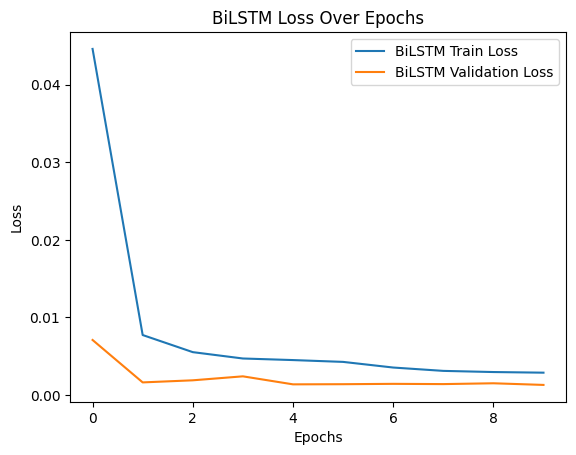

In [70]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the BiLSTM model
bilstm_history = bilstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Step 10: Evaluate BiLSTM Model
bilstm_loss = bilstm_model.evaluate(X_test, y_test)
print(f"BiLSTM Test Loss: {bilstm_loss}")

# Plotting the training and validation loss for BiLSTM
plt.plot(bilstm_history.history['loss'], label='BiLSTM Train Loss')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM Validation Loss')
plt.title('BiLSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 11: Make Predictions using BiLSTM



In [71]:
y_pred_bilstm = bilstm_model.predict(X_test)
y_pred_bilstm = scaler_y.inverse_transform(y_pred_bilstm)  # Reverse scaling for predictions
y_test_actual = scaler_y.inverse_transform(y_test)  # Reverse scaling for actual values

# Calculate metrics for BiLSTM
mse_bilstm = mean_squared_error(y_test_actual, y_pred_bilstm)
rmse_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_actual, y_pred_bilstm)
r2_bilstm = r2_score(y_test_actual, y_pred_bilstm)
mape_bilstm = np.mean(np.abs((y_test_actual - y_pred_bilstm) / y_test_actual)) * 100

print("BiLSTM Metrics:")
print(f"R²: {r2_bilstm}")
print(f"MSE: {mse_bilstm}")
print(f"RMSE: {rmse_bilstm}")
print(f"MAE: {mae_bilstm}")
print(f"MAPE: {mape_bilstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
BiLSTM Metrics:
R²: -0.6017553291824302
MSE: 0.03551562833751007
RMSE: 0.18845590555222744
MAE: 0.15075097850777358
MAPE: 64.23421517775238


# **Lstm with Z-score transformation**

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 4.4329e-04 - val_loss: 5.0486e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0855e-04 - val_loss: 3.2051e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6636e-05 - val_loss: 2.4488e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7510e-05 - val_loss: 2.3729e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0521e-05 - val_loss: 2.2567e-05
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1092e-05 - val_loss: 2.1097e-05
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2159e-05 - val_loss: 2.1789e-05
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7174e-05 - val_loss: 1.9971e-05
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9963e-05 - val_loss: 1.9141e-05
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2079e-05 - val_loss: 1.9720e-05
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9241e-05 - val_l

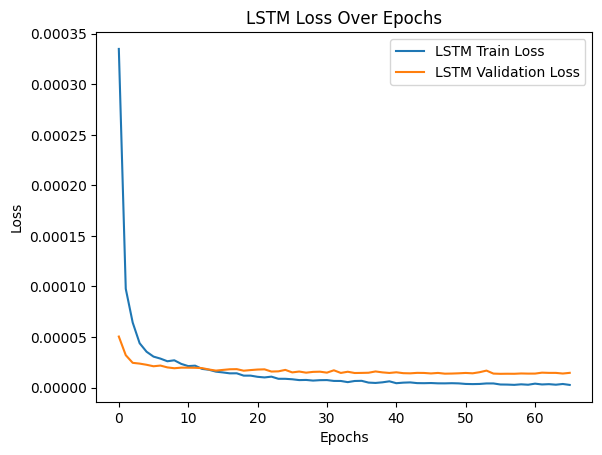

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Mean Squared Error: 4.997313695331472
Mean Absolute Error: 0.26180077302887883
R^2 Score: -0.03244658579264614


In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load the Dataset
data = pd.read_csv('normalized gpa form.csv')
data

# Step 2: Handle Missing Data
# Impute numerical columns with their median
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
data[numerical_columns] = imputer_num.fit_transform(data[numerical_columns])

# Impute categorical columns with the most frequent value
categorical_columns = data.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = imputer_cat.fit_transform(data[categorical_columns])

# Step 3: Encoding Categorical Variables
# Label Encoding for binary categories and One-Hot Encoding for others
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

for col in categorical_columns:
    if data[col].nunique() == 2:  # Binary categories
        data[col] = label_encoder.fit_transform(data[col])
    else:  # Non-binary categories
        encoded = one_hot_encoder.fit_transform(data[[col]])
        encoded_df = pd.DataFrame(encoded, columns=[f"{col}_{cat}" for cat in one_hot_encoder.categories_[0][1:]])
        data = pd.concat([data, encoded_df], axis=1)
        data.drop(columns=[col], inplace=True)

# Step 4: Z-Score Transformation
# Apply Z-score (Standardization) to numerical features (except the target column)
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()

for col in numerical_columns:
    data[col] = scaler.fit_transform(data[[col]])

# Standardize the target column 'current_cgpa'
target_column = 'current_cgpa'
data[target_column] = scaler.fit_transform(data[[target_column]])

# Step 5: Feature Scaling (already standardized)
X = data.drop(columns=[target_column]).values
y = data[target_column].values

# Scaling features and target (Using MinMaxScaler for features and StandardScaler for the target)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Step 6: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 7: Build and Train LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Step 8: Evaluate LSTM Model
lstm_loss = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Loss: {lstm_loss}")

# Plotting the training and validation loss for LSTM
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 9: Make Predictions using LSTM
# Predict on test set
y_pred_scaled = lstm_model.predict(X_test)

# Inverse transform predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# Step 10: Build and Train BiLSTM Model (Optional)
# You can proceed with BiLSTM model as needed, following the same structure.


In [73]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)  # Reverse scaling for predictions
y_test_actual = scaler_y.inverse_transform(y_test)  # Reverse scaling for actual values

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test_actual - y_pred_lstm) / y_test_actual)) * 100

print("LSTM Metrics:")
print(f"R²: {r2_lstm}")
print(f"MSE: {mse_lstm}")
print(f"RMSE: {rmse_lstm}")
print(f"MAE: {mae_lstm}")
print(f"MAPE: {mape_lstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Metrics:
R²: -0.03244658579264614
MSE: 4.997313695331472
RMSE: 2.235467220813464
MAE: 0.26180077302887883
MAPE: 210.58432089415885


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 0.0013 - val_loss: 1.7602e-04
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.0463e-04 - val_loss: 5.2836e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.8753e-05 - val_loss: 3.2119e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.5927e-05 - val_loss: 2.5974e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.2231e-05 - val_loss: 2.6056e-05
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.7206e-05 - val_loss: 2.2274e-05
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.0013e-05 - val_loss: 2.4140e-05
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.3407e-05 - val_loss: 2.2591e-05
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.3835e-05 - val_loss: 2.2697e-05
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.4270e-05 - val_loss: 2.3569e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 
BiLSTM T

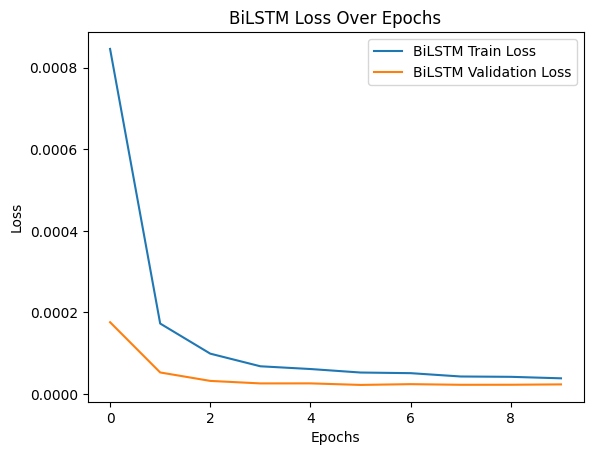

In [74]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the BiLSTM model
bilstm_history = bilstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Step 10: Evaluate BiLSTM Model
bilstm_loss = bilstm_model.evaluate(X_test, y_test)
print(f"BiLSTM Test Loss: {bilstm_loss}")

# Plotting the training and validation loss for BiLSTM
plt.plot(bilstm_history.history['loss'], label='BiLSTM Train Loss')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM Validation Loss')
plt.title('BiLSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 11: Make Predictions using BiLSTM



In [75]:
y_pred_bilstm = bilstm_model.predict(X_test)
y_pred_bilstm = scaler_y.inverse_transform(y_pred_bilstm)  # Reverse scaling for predictions
y_test_actual = scaler_y.inverse_transform(y_test)  # Reverse scaling for actual values

# Calculate metrics for BiLSTM
mse_bilstm = mean_squared_error(y_test_actual, y_pred_bilstm)
rmse_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_actual, y_pred_bilstm)
r2_bilstm = r2_score(y_test_actual, y_pred_bilstm)
mape_bilstm = np.mean(np.abs((y_test_actual - y_pred_bilstm) / y_test_actual)) * 100

print("BiLSTM Metrics:")
print(f"R²: {r2_bilstm}")
print(f"MSE: {mse_bilstm}")
print(f"RMSE: {rmse_bilstm}")
print(f"MAE: {mae_bilstm}")
print(f"MAPE: {mape_bilstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
BiLSTM Metrics:
R²: -0.053533976320981
MSE: 5.099382225496783
RMSE: 2.258181176410959
MAE: 0.5286468279553699
MAPE: 1093.8843774279255
